Name: Jeong, Jinhong </n>
Student ID: 20552827

#Description
This project aims to explore how  the demographical features and medical nature affects the patient's length of hospital stay.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import shap
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

##Part1: Process the data
Fetch the csv file to a panda dataframe and trying to categorize the columns of data accordingly to its type of data. 

In [4]:
#[AAYUSH CHOUDHURY]. ([2022; September]). [LengthOfStay], [csv files]. Retrieved [01/05/2023] from [https://www.kaggle.com/datasets/aayushchou/hospital-length-of-stay-dataset-microsoft].
training_data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/LengthOfStay.csv")
cols = training_data.shape[1] #28
rows = training_data.shape[0] #1000000
y_val = training_data.iloc[:, -1:]#response variable lengthofstay
x_val = training_data.iloc[:, :-1] #dataset other than 
columns = training_data.columns

##Check the missing values

In [5]:
training_data.isnull().sum() #no missing values concluded

eid                           0
vdate                         0
rcount                        0
gender                        0
dialysisrenalendstage         0
asthma                        0
irondef                       0
pneum                         0
substancedependence           0
psychologicaldisordermajor    0
depress                       0
psychother                    0
fibrosisandother              0
malnutrition                  0
hemo                          0
hematocrit                    0
neutrophils                   0
sodium                        0
glucose                       0
bloodureanitro                0
creatinine                    0
bmi                           0
pulse                         0
respiration                   0
secondarydiagnosisnonicd9     0
discharged                    0
facid                         0
lengthofstay                  0
dtype: int64

In [6]:
training_data.describe()

,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,...,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,50000.500000,0.036420,0.035270,0.094940,0.039450,0.063060,0.239040,0.051660,0.049390,0.004790,...,10.177455,137.891397,141.963384,14.097185,1.099350,29.805759,73.444720,6.493768,2.123310,4.00103
std,28867.657797,0.187334,0.184462,0.293134,0.194664,0.243072,0.426499,0.221341,0.216682,0.069044,...,5.353131,2.999669,29.992996,12.952454,0.200262,2.003769,11.644555,0.568473,2.050641,2.36031
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.100000,124.912632,-1.005927,1.000000,0.219770,21.992683,21.000000,0.200000,0.000000,1.00000
25%,25000.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.700000,135.871062,121.682383,11.000000,0.964720,28.454235,66.000000,6.500000,1.000000,2.00000
50%,50000.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.400000,137.887151,142.088545,12.000000,1.098764,29.807516,73.000000,6.500000,1.000000,4.00000
75%,75000.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.500000,139.912885,162.180996,14.000000,1.234867,31.156885,81.000000,6.500000,3.000000,6.00000
max,100000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,245.900000,151.387283,271.444277,682.500000,2.035202,38.935293,130.000000,10.000000,10.000000,17.00000


In [7]:
training_data.drop_duplicates(inplace = True)
#there is no duplicates for eid, which refers to unique ID of hospital admission

In [8]:
#segregated data upon its feature 
datetime_cols = ["vdate", "discharged"]
cat_cols = ["gender", "rcount", "facid"]
bin_cols = ["dialysisrenalendstage", 
            "asthma", 
            "irondef", 
            "pneum", 
            "substancedependence", 
            "psychologicaldisordermajor",
            "depress",
            "psychother",
            "fibrosisandother",
            "malnutrition",
            "hemo"]
num_cols = ["hematocrit",
            "neutrophils",
            "sodium",
            "glucose",
            "bloodureanitro",
            "creatinine",
            "bmi",
            "pulse",
            "respiration"]
resp_cols = ["lengthofstay"]
for date_col, cat_col in zip(datetime_cols, cat_cols): 
    training_data[date_col] = pd.to_datetime(training_data[date_col], format="%m/%d/%Y")
    training_data[cat_col] = training_data[cat_col].astype("category")

In [9]:
scaler = StandardScaler()
scaler.fit(training_data[num_cols]) 
num_df = scaler.transform(training_data[num_cols])
num_df = pd.DataFrame(data = num_df, columns = num_cols)

In [10]:
num_df

,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration
0,-0.234247,0.751441,0.823340,1.684186,-0.161915,1.454965,0.312741,1.936991,0.010963
1,-1.464694,-1.135314,-0.386613,-1.596543,-0.470738,-0.779911,-0.671360,-1.068721,0.010963
2,-1.760001,-0.238638,-1.611147,-0.381186,-0.161915,-0.167779,-0.480071,-0.811089,0.010963
3,-0.037375,-0.145235,0.367584,0.713958,-0.161915,-0.961187,-0.921644,0.219441,0.010963
4,-1.415476,-0.210617,0.247842,-1.569599,-0.200518,0.716587,0.226159,-0.553456,-1.572234
...,...,...,...,...,...,...,...,...,...
99995,0.011843,-0.163915,-1.759010,0.982207,-0.161915,-2.242209,0.128413,0.562951,0.010963
99996,0.011843,-0.163915,0.145324,-0.654187,-0.161915,2.107623,-0.417321,-1.068721,0.010963
99997,1.980558,-0.462807,-0.398543,-1.122777,-0.161915,-0.367884,-1.722183,-1.068721,0.714606
99998,1.143854,-0.369404,-0.637034,-1.007329,0.146908,-0.319335,-0.305574,-1.240476,-1.572234


###1.Linear Regression
  Linear Regression model applied to see the relation between the number of disease a patient(example) have with standardized  num_cols which are the numerical values. Hence, try to pick the top 5 'num_cols' variable with highest linear correlation with total number of disease.

In [11]:
disease_sum = pd.DataFrame(data = training_data[bin_cols].sum(axis = 1), columns = ['disease_sum'])
scaler.fit(disease_sum['disease_sum'].to_numpy().reshape(-1 ,1))
disease_sum = scaler.transform(disease_sum['disease_sum'].to_numpy().reshape(-1, 1))
disease_sum = pd.DataFrame(data = disease_sum, columns = ['disease_sum'])
x_train, x_test, y_train, y_test = train_test_split(num_df, disease_sum)

In [12]:
num_df

,hematocrit,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration
0,-0.234247,0.751441,0.823340,1.684186,-0.161915,1.454965,0.312741,1.936991,0.010963
1,-1.464694,-1.135314,-0.386613,-1.596543,-0.470738,-0.779911,-0.671360,-1.068721,0.010963
2,-1.760001,-0.238638,-1.611147,-0.381186,-0.161915,-0.167779,-0.480071,-0.811089,0.010963
3,-0.037375,-0.145235,0.367584,0.713958,-0.161915,-0.961187,-0.921644,0.219441,0.010963
4,-1.415476,-0.210617,0.247842,-1.569599,-0.200518,0.716587,0.226159,-0.553456,-1.572234
...,...,...,...,...,...,...,...,...,...
99995,0.011843,-0.163915,-1.759010,0.982207,-0.161915,-2.242209,0.128413,0.562951,0.010963
99996,0.011843,-0.163915,0.145324,-0.654187,-0.161915,2.107623,-0.417321,-1.068721,0.010963
99997,1.980558,-0.462807,-0.398543,-1.122777,-0.161915,-0.367884,-1.722183,-1.068721,0.714606
99998,1.143854,-0.369404,-0.637034,-1.007329,0.146908,-0.319335,-0.305574,-1.240476,-1.572234


In [13]:
from  sklearn.linear_model import LinearRegression
MSE_values = dict()

In [14]:

def Lin_scores(x_train, y_train, y_test, columns):
  model = LinearRegression()
  R2_scores = dict() 
  coef_list = dict()
  intercept_list = dict()
  for col in columns:
    reg = model.fit(x_train[col].to_numpy().reshape(-1, 1), y_train)
    R2_scores[col] = reg.score(x_test[col].to_numpy().reshape(-1, 1), y_test)
    coef_list[col] = reg.coef_
    intercept_list[col] = reg.intercept_
  return R2_scores, coef_list, intercept_list
R2_scores, coef_list, intercept_list = Lin_scores(x_train, y_train, y_test, num_cols)
print(R2_scores)
print(coef_list)
print(intercept_list)

{'hematocrit': 0.03151779245140873, 'neutrophils': 0.021866834077084008, 'sodium': -3.544951188527712e-05, 'glucose': 4.531733520996006e-06, 'bloodureanitro': 0.07213663838342455, 'creatinine': 5.9944458995375705e-05, 'bmi': 5.967875249868193e-06, 'pulse': 1.7126501945963213e-05, 'respiration': 0.0016546941753738942}
{'hematocrit': array([[-0.18402603]]), 'neutrophils': array([[-0.1197818]]), 'sodium': array([[-0.00350977]]), 'glucose': array([[-0.00073093]]), 'bloodureanitro': array([[0.3009725]]), 'creatinine': array([[-0.0047606]]), 'bmi': array([[-0.00053546]]), 'pulse': array([[0.00905468]]), 'respiration': array([[-0.04803023]])}
{'hematocrit': array([0.0002578]), 'neutrophils': array([0.00036285]), 'sodium': array([0.0002181]), 'glucose': array([0.0002126]), 'bloodureanitro': array([-0.00032782]), 'creatinine': array([0.00022276]), 'bmi': array([0.00021151]), 'pulse': array([0.00021432]), 'respiration': array([0.00020727])}


List of scores : R2, coefficient, intercept list for linear regression model where featrue variables: num_cols and response_variables: disease issuse(featured variablea aggregating the total number of sick issues).

In [15]:
from sklearn.metrics import mean_squared_error

In [ ]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches([20,30])
for i,ax in enumerate(axs.flat):
  key_val = num_cols[i] 
  ax.scatter(x_test[key_val], y_test)
  xfit = np.linspace(x_test[key_val].min(), x_test[key_val].max(), x_test[key_val].shape[0])
  yfit = coef_list[key_val] * xfit + intercept_list[key_val]
  x_shape = xfit.shape
  ax.plot(xfit, np.reshape(yfit, x_shape), 'r', linewidth = 5)
  R2_val = R2_scores[key_val]
  MSE_values[key_val] = mean_squared_error(x_test[key_val], np.reshape(yfit, x_shape))
  ax.set_title("number of disease vs " + key_val +'\n' + "(R^2 = " + str(R2_val) + ")")
  ax.set(xlabel= key_val ,ylabel="number of disease")

According to the R2 score value and the plot above, the most relevant 

Furthermore, check the correlation(R2 score) between length of stay and no. of disease:
  Confirmed that number of disease infected is positively correlated to length of stay in hospital. Hence 'bloodurineato' is also likely to be positively correlated to the stay of hospital.


In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(disease_sum, training_data[resp_cols])
model = LinearRegression()
reg2 = model.fit(x_train2.to_numpy().reshape(-1, 1), y_train2)
R2_score2 = reg2.score(x_test2.to_numpy().reshape(-1, 1), y_test2)
coef2 = reg2.coef_
intercept2 = reg2.intercept_
plt.figure(figsize = (10, 10))
plt.scatter(x_test2, y_test2)
xfit = np.linspace(x_test2.min(), x_test2.max(), x_test2.shape[0])
yfit = coef2 * xfit + intercept2
x_shape = xfit.shape
plt.plot(xfit, np.reshape(yfit, x_shape), 'r', linewidth = 5)
plt.suptitle("no. of disease vs " + "length of stay" +'\n' + "(R^2 = " + str(R2_score2) + ")")
plt.xlabel("no. of disease")
plt.ylabel("length of stay")

###2.Feedforward neural network 
Figure out which MLP model has highest regression value to see what number of neuron for hidden layer is enough for feedforward neural network.

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from statistics import mean
from statistics import stdev

In [19]:
X = training_data[['bloodureanitro', 'neutrophils', 'hematocrit']]
Y = training_data[['lengthofstay']]
X, Y = make_regression(n_samples=1000, random_state=42)
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y,test_size = 0.2,random_state =42)
H = (1, 10, 100, 200)
mlp_list = list()
R2_scores = list()
for val in H:
  regr = MLPRegressor( hidden_layer_sizes=(val, val), early_stopping = True, max_iter = 1000, random_state =42)
  R2 = list()
  for i in range(3):
    #regr = MLPRegressor(hidden_layer_sizes=(val, val, val), early_stopping = True, max_iter = 1000, random_state =4211)
    #start measuring the training time 
    #start the training
    regr.fit(X_train3, Y_train3)
    #regr.predict(X_test[:2])
    print(f"regr score for H = {val} in {i + 1} trial: {regr.score(X_test3, Y_test3)}")
    R2.append(regr.score(X_test3, Y_test3))
  R2_scores.append(R2)
R2_scores_mean = [mean(R2s) for R2s in R2_scores]
R2_scores_stdev = [stdev(R2s) for R2s in R2_scores]

regr score for H = 1 in 1 trial: -7.376703326622547e-06
regr score for H = 1 in 2 trial: -7.376703326622547e-06
regr score for H = 1 in 3 trial: -7.376703326622547e-06
regr score for H = 10 in 1 trial: 0.9399495027554409
regr score for H = 10 in 2 trial: 0.9399495027554409
regr score for H = 10 in 3 trial: 0.9399495027554409
regr score for H = 100 in 1 trial: 0.9372510272827255
regr score for H = 100 in 2 trial: 0.9372510272827255
regr score for H = 100 in 3 trial: 0.9372510272827255
regr score for H = 200 in 1 trial: 0.9389636979960514
regr score for H = 200 in 2 trial: 0.9389636979960514
regr score for H = 200 in 3 trial: 0.9389636979960514


In [20]:
R2_scores_mean
#the best model is the model with 

[-7.376703326622547e-06,
 0.9399495027554409,
 0.9372510272827255,
 0.9389636979960514]

###Classification
-This classification process uses selectKbest method. Use the mutual information statistic  as the score for the feature selection to select features that are relevant to each of the features in bin_cols to see which num_cols feature is highly correlated to features in bin_cols.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [24]:
X = training_data[num_cols]
Y = training_data[bin_cols]
x_train4, x_test4, y_train4, y_test4 = train_test_split(X, Y)
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=mutual_info_classif, k = 3)
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs
result = list()
for col in bin_cols:
  X_train_fs, X_test_fs, fs = select_features(x_train4, y_train4[col], x_test4)
  fs_score_records = zip(fs.feature_names_in_, fs.scores_)
  zipped = list(fs_score_records)
  res = sorted(zipped, key = lambda x: x[1])
  res = res[len(bin_cols) - 3:]
  result.append(res)
result = zip(bin_cols, result)
result = list(result)
result

[('dialysisrenalendstage', [('bloodureanitro', 0.04536286251639954)]),
 ('asthma', [('respiration', 0.007575681204710971)]),
 ('irondef', [('bloodureanitro', 0.05060069749809304)]),
 ('pneum', [('bloodureanitro', 0.017302250313661505)]),
 ('substancedependence', [('bloodureanitro', 0.015608385181946405)]),
 ('psychologicaldisordermajor', [('bloodureanitro', 0.04123643013909284)]),
 ('depress', [('respiration', 0.015051671039675085)]),
 ('psychother', [('bloodureanitro', 0.0815165189760827)]),
 ('fibrosisandother', [('neutrophils', 0.01155171187086479)]),
 ('malnutrition', [('bloodureanitro', 0.061058390011225594)]),
 ('hemo', [('hematocrit', 0.06809291801453532)])]

Conclusively,  selectKbest methods reveals  features, 'bloodureanitro', 'respiration', 'neutrophils' and 'hematocrit'.

In [25]:
feature4 = ['bloodureanitro', 'respiration', 'neutrophils', 'hematocrit']

Logistic regression with different learning rate. Finding out the optimal learning rate for each features in bin col. 

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [27]:
X = training_data[feature4]
Y = training_data[bin_cols]
x_train5, x_test5, y_train5, y_test5 = train_test_split(X, Y)
eta0_list = list()
f1_scores_mean = list()
f1_scores_stdev = list()
accuracy_scores_mean = list()
accuracy_scores_stdev = list()
times_mean = list()
times_stdev = list()

In [28]:
for col in bin_cols: #for each of the bianry columns
  i = 0.3
  while i < 1: # 0.3, 0.5, 0.7, 0.9
    logreg = SGDClassifier(eta0 = 1 - i, loss = "log_loss", max_iter=1000)
    eta0_list.append(1 - i)
    f1_scores_list = list()
    accuracy_scores_list = list()
    for j in range(3):
      logreg.fit(x_train5, y_train5[col])
      score = logreg.score(x_train5, y_train5[col])
      ypred = logreg.predict(x_test5)
      print(f"Score for when eta0 = {1- i} in {j + 1} trials: {score} and {col}")
      print('Accuracy: {:.4f}'.format(accuracy_score(y_test5[col], ypred)))
      print('F1_score: {:.4f}'.format(f1_score(y_test5[col], ypred)))
      f1_scores_list.append(f1_score(y_test5[col], ypred)) # get the f1_scroes 
      accuracy_scores_list.append(accuracy_score(y_test5[col] , ypred))
    print(f"f1 means is {mean(f1_scores_list)}")
    f1_scores_mean.append(mean(f1_scores_list))
    print(f"f1 stdev is {stdev(f1_scores_list)}")
    f1_scores_stdev.append(stdev(f1_scores_list))
    print(f"accuracy mean is {mean(accuracy_scores_list)}")
    accuracy_scores_mean.append(mean(accuracy_scores_list))
    print(f"accuracy stdev is {stdev(accuracy_scores_list)}")
    accuracy_scores_stdev.append(stdev(accuracy_scores_list))
    i += 0.2

Score for when eta0 = 0.7 in 1 trials: 0.9604666666666667 and dialysisrenalendstage
Accuracy: 0.9626
F1_score: 0.2642
Score for when eta0 = 0.7 in 2 trials: 0.96256 and dialysisrenalendstage
Accuracy: 0.9640
F1_score: 0.0507
Score for when eta0 = 0.7 in 3 trials: 0.9616666666666667 and dialysisrenalendstage
Accuracy: 0.9636
F1_score: 0.2196
f1 means is 0.1781304507689716
f1 stdev is 0.11259979976760637
accuracy mean is 0.9634
accuracy stdev is 0.0007600000000000209
Score for when eta0 = 0.5 in 1 trials: 0.9620266666666667 and dialysisrenalendstage
Accuracy: 0.9638
F1_score: 0.2025
Score for when eta0 = 0.5 in 2 trials: 0.9627733333333334 and dialysisrenalendstage
Accuracy: 0.9646
F1_score: 0.0264
Score for when eta0 = 0.5 in 3 trials: 0.9627466666666666 and dialysisrenalendstage
Accuracy: 0.9646
F1_score: 0.0242
f1 means is 0.08436550129542952
f1 stdev is 0.10228275693609389
accuracy mean is 0.9643066666666666
accuracy stdev is 0.00047384948383780856
Score for when eta0 = 0.30000000000

In [29]:
len(accuracy_scores_mean)
accuracy_scores = dict()
steps = 4 
n = len(accuracy_scores_mean)
i = 0 
eta0 = [0.3, 0.5, 0.7, 0.9]
for col in bin_cols:
  accuracy_scores[col] = accuracy_scores_mean[i:i + 4]
  i = i + 4
  accuracy_scores[col] = list(zip(eta0, accuracy_scores[col]))


In [ ]:
accuracy_scores

###Feedforward nerual network on logistis regression
Neural network classifiers generalize logistic regression by introducing  different neuron number for each hidden layer(in total 2 hidden layers).
H is in {10, 10, 100, 200}.


In [31]:
from sklearn.neural_network import MLPClassifier

In [32]:
training_data[feature4]

,bloodureanitro,respiration,neutrophils,hematocrit
0,12.0,6.5,14.20,11.5
1,8.0,6.5,4.10,9.0
2,12.0,6.5,8.90,8.4
3,12.0,6.5,9.40,11.9
4,11.5,5.6,9.05,9.1
...,...,...,...,...
99995,12.0,6.5,9.30,12.0
99996,12.0,6.5,9.30,12.0
99997,12.0,6.9,7.70,16.0
99998,16.0,5.6,8.20,14.3


In [33]:
scaler = StandardScaler()
H = (1, 10, 100, 200)
X = training_data[feature4]
Y = training_data[bin_cols]
scaler.fit(X)
X = scaler.transform(X)
x_train6, x_test6, y_train6, y_test6 = train_test_split(X, Y)
training_time_mean2 = list()
training_time_stdev2 = list()
F1_scores_mean2 = list()
F1_scores_stdev2 = list()
accuracy_mean2 = list()
accuracy_stdev2 = list()

In [ ]:
for val in H: # for each number of neurons, see wjats 
  log_reg_model = MLPClassifier(learning_rate = "constant", hidden_layer_sizes=(val, val, val), early_stopping = True, max_iter = 1000, random_state = 42)
  time = list()
  F1 = list()
  accuracy = list()
  for col in bin_cols: # for each of the bin_cols(disease )
    log_reg_model.fit(x_train6, y_train6[col])
    ypred = log_reg_model.predict(x_test6)
    F1.append(f1_score(y_test6[col], ypred))
    accuracy.append(accuracy_score(y_test6[col], ypred))
  print(f"Description when model is H = {val}")
  print(f"F1_scores mean is {mean(F1)}")
  F1_scores_mean2.append(mean(F1))
  print(f"F1_scores stdev is {stdev(F1)}")
  F1_scores_stdev2.append(stdev(F1))
  print(f"Accuracy mean is {mean(accuracy)}")
  accuracy_mean2.append(mean(accuracy))
  print(f"Accuracy stdev is {stdev(accuracy)}")
  accuracy_stdev2.append(stdev(accuracy))

Description when model is H = 1
F1_scores mean is 0.0
F1_scores stdev is 0.0
Accuracy mean is 0.9327854545454546
Accuracy stdev is 0.06199944586262628


Training interrupted by user.


Description when model is H = 10
F1_scores mean is 0.11010399430864296
F1_scores stdev is 0.14537672910047403
Accuracy mean is 0.9349236363636364
Accuracy stdev is 0.05893304256064289


Training interrupted by user.
Training interrupted by user.
Training interrupted by user.
Training interrupted by user.
Training interrupted by user.
Training interrupted by user.


###Hyperparameter tuning
Use grid search to tune the hyperparameter of a two hidden-layer feedforward neural network to predict whether or not the patient has the disease in bin_cols or not

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [22]:
test_data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/LengthOfStay.csv")

In [23]:
scaler = StandardScaler()
x = test_data[num_cols]
y = test_data[bin_cols]
scaler.fit(x)
x = scaler.transform(x)
x, y = make_classification(n_samples=1000, random_state=42)

In [24]:
x_train,x_cv,y_train,y_cv = train_test_split(x, y, random_state =42)
mlp = MLPClassifier(early_stopping = True, random_state = 42)
param = {
      'hidden_layer_sizes': [(100, 100), (200, 200)],
      'learning_rate': ['constant'],
      'learning_rate_init': [0.1],
      'activation': ["relu"],
      'solver': ['sgd','adam', 'lbfgs']
    }
grid_search = GridSearchCV(mlp, param, cv = 5, scoring = 'accuracy', verbose = True) 
grid_search.fit(x_train, y_train)
grid_search.cv_results_
best_param = {
    'activation': ['relu'],
   'hidden_layer_sizes': [(200, 200)],
   'learning_rate': ['constant'],
   'learning_rate_init': [0.1],
   'solver': ['sgd']
   }
grid_search_best = GridSearchCV(mlp, best_param, cv = 5, scoring = 'accuracy', verbose = True)
grid_search_best.fit(x_train, y_train)
pred = grid_search_best.predict(x_cv)
best_score = grid_search_best.score(x_cv, y_cv)
#preds = list()
#best_scores = list()
#for col in bin_cols:
 # grid_search_best = GridSearchCV(mlp, best_param, cv = 5, scoring = 'accuracy', verbose = True)
#  grid_search_best.fit(x_train, y_train[col])
 # pred = grid_search_best.predict(x_cv)
 # preds.append(pred)
 # best_score = grid_search_best.score(x_cv, y_cv[col])
  #best_scores.append(best_score)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


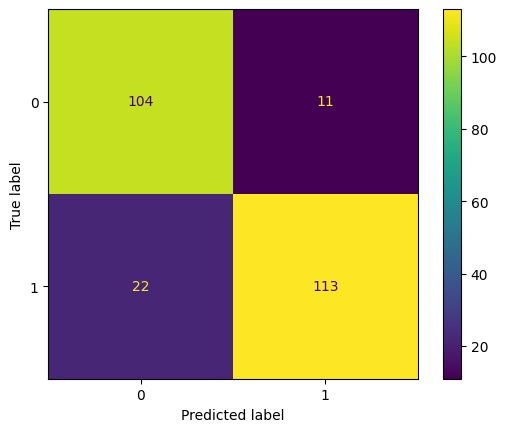

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#plot_confusion_matrix(grid_search_best, X_cv, Y_cv)

cm = confusion_matrix(y_cv, pred, labels=grid_search_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_best.classes_)
disp.plot()

In [ ]:
f1_score(y_cv, pred)

0.8725868725868726

In [ ]:
accuracy_score(y_cv, pred)

0.868

###Random forest tree
Predict the stay of patient according to his medical status in hospital. The predicted number of patient staying in hospital is the averaged value for each of the patient either sick, have one of the disease in bin_cols or have more than one disease.

In [25]:
from collections import defaultdict 

In [26]:
dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/LengthOfStay.csv")
#get the average 
df = dataset
diseases = defaultdict(list)
for index, row in df.iterrows():
  if row[bin_cols].sum() == 0:
    diseases['no disesaes'].append(row['lengthofstay'])
  if row[bin_cols].sum() == 1:
    for col in bin_cols:
      if row[col] == 1:
         diseases[col].append(row['lengthofstay'])
  else:
    diseases["two more"].append(row['lengthofstay'])

In [27]:
los_avg = dict()
for key in diseases:
  los_avg[key]= mean(diseases[key])


In [28]:
los_avg

{'no disesaes': 3.1089098550775187,
 'two more': 3.701252446183953,
 'psychologicaldisordermajor': 4.957067968185105,
 'substancedependence': 4.853820598006645,
 'asthma': 4.858793324775353,
 'malnutrition': 4.92638036809816,
 'fibrosisandother': 5.487804878048781,
 'hemo': 5.219364058592355,
 'pneum': 4.980558930741191,
 'irondef': 4.955103769589157,
 'dialysisrenalendstage': 5.23091976516634,
 'psychother': 5.207001522070016,
 'depress': 4.872531418312388}

In [29]:
X = dataset[num_cols]
Y = dataset[bin_cols]
x_train, x_test, y_train, y_test = train_test_split(X, Y)


In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn import tree

In [31]:
import warnings
warnings.filterwarnings('ignore')

The col used: dialysisrenalendstage
                          precision    recall  f1-score   support

no dialysisrenalendstage       0.96      1.00      0.98     24098
   dialysisrenalendstage       0.00      0.00      0.00       902

                accuracy                           0.96     25000
               macro avg       0.48      0.50      0.49     25000
            weighted avg       0.93      0.96      0.95     25000

The col used: asthma
              precision    recall  f1-score   support

   no asthma       0.97      1.00      0.98     24156
      asthma       0.00      0.00      0.00       844

    accuracy                           0.97     25000
   macro avg       0.48      0.50      0.49     25000
weighted avg       0.93      0.97      0.95     25000

The col used: irondef
              precision    recall  f1-score   support

  no irondef       0.90      1.00      0.95     22619
     irondef       0.00      0.00      0.00      2381

    accuracy                   

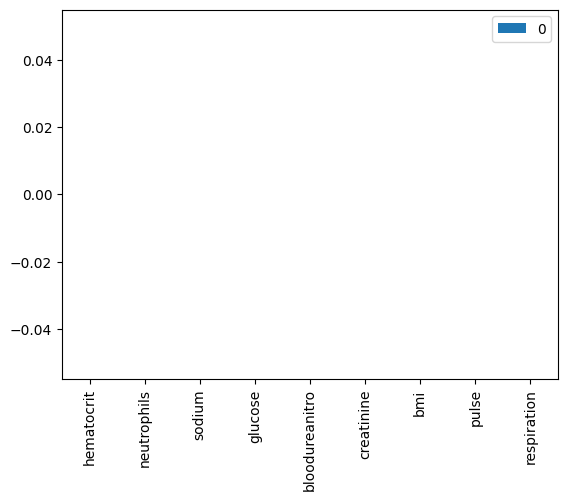

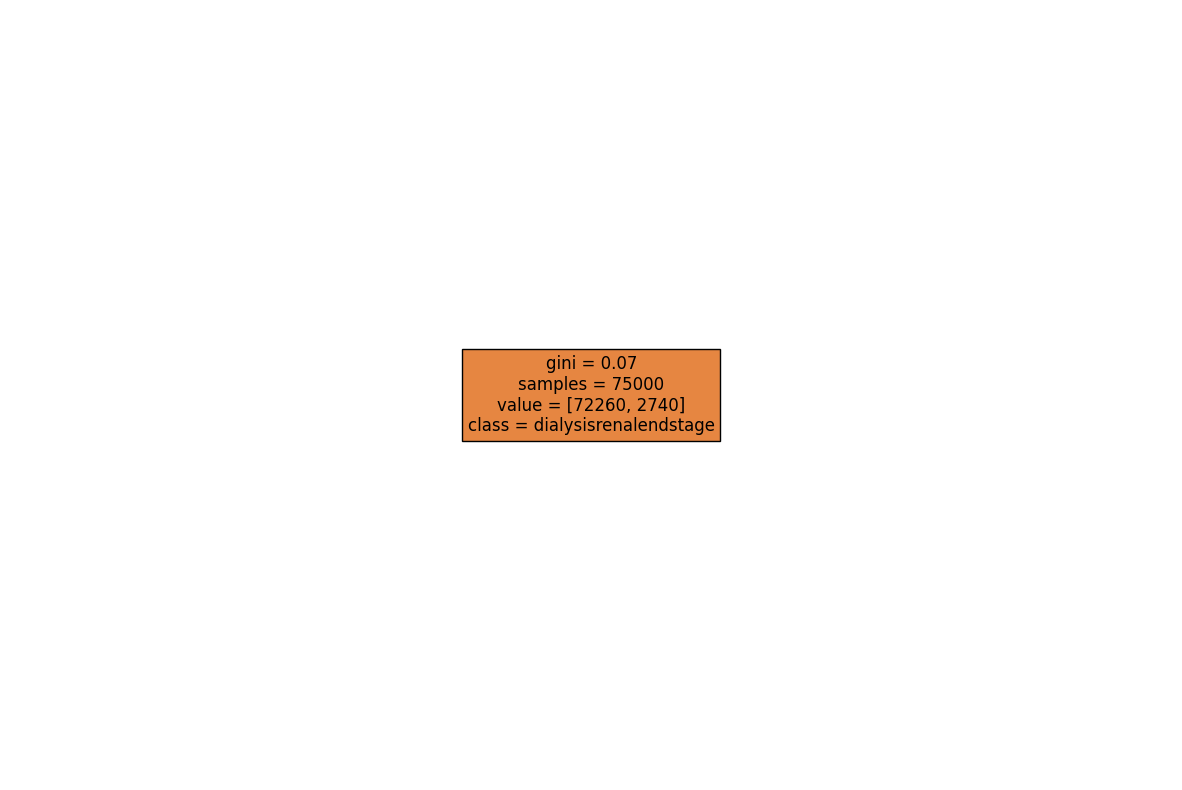

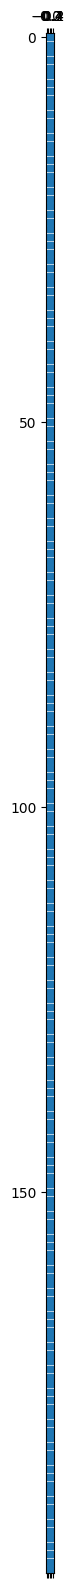

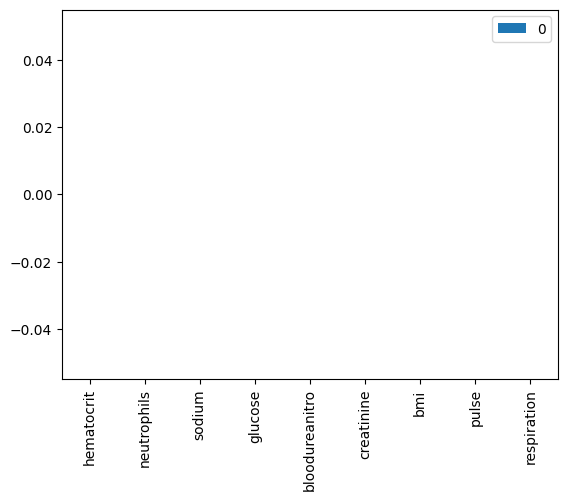

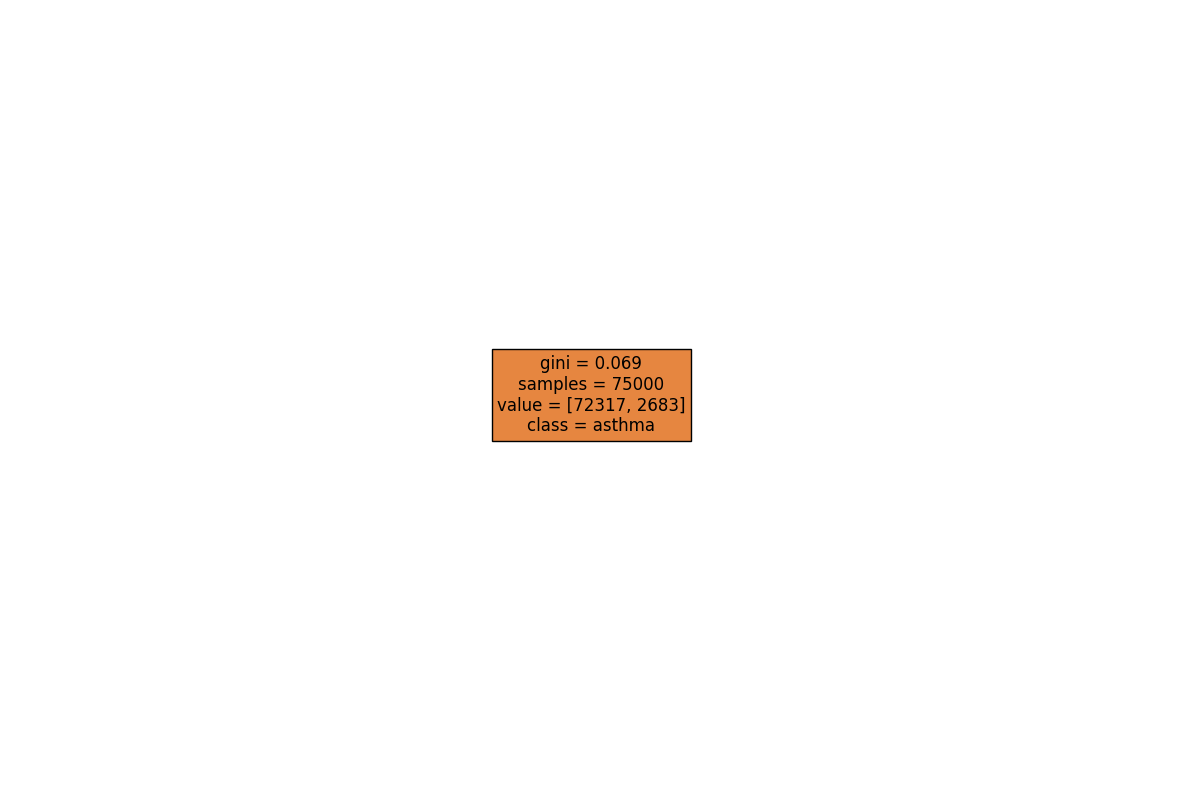

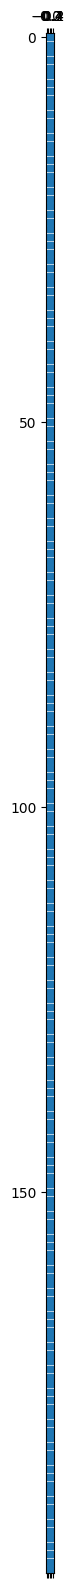

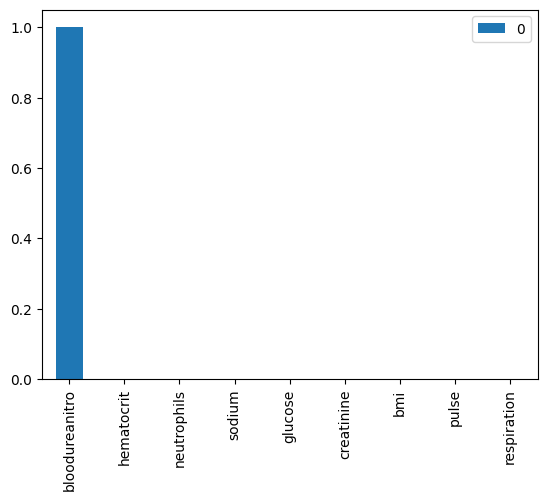

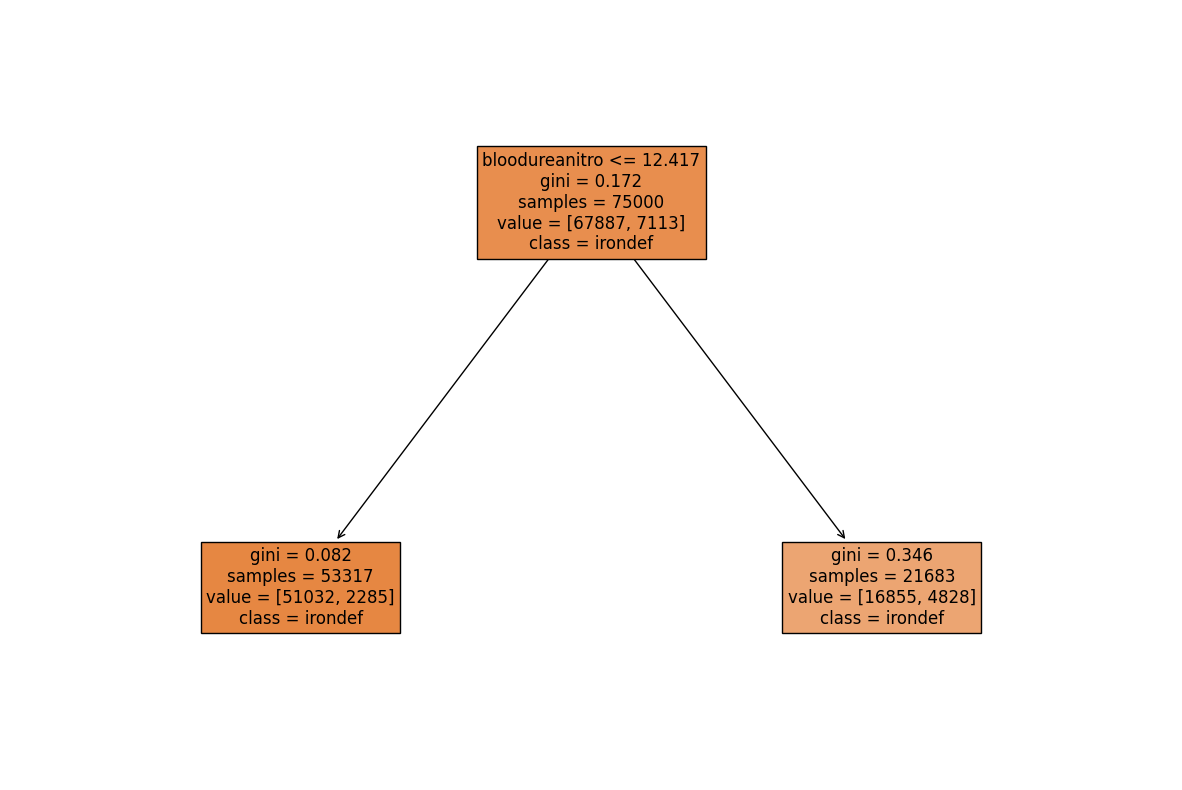

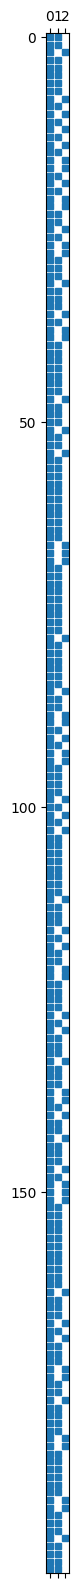

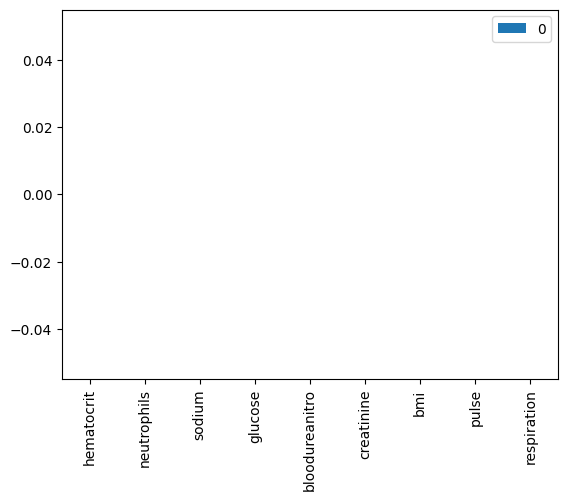

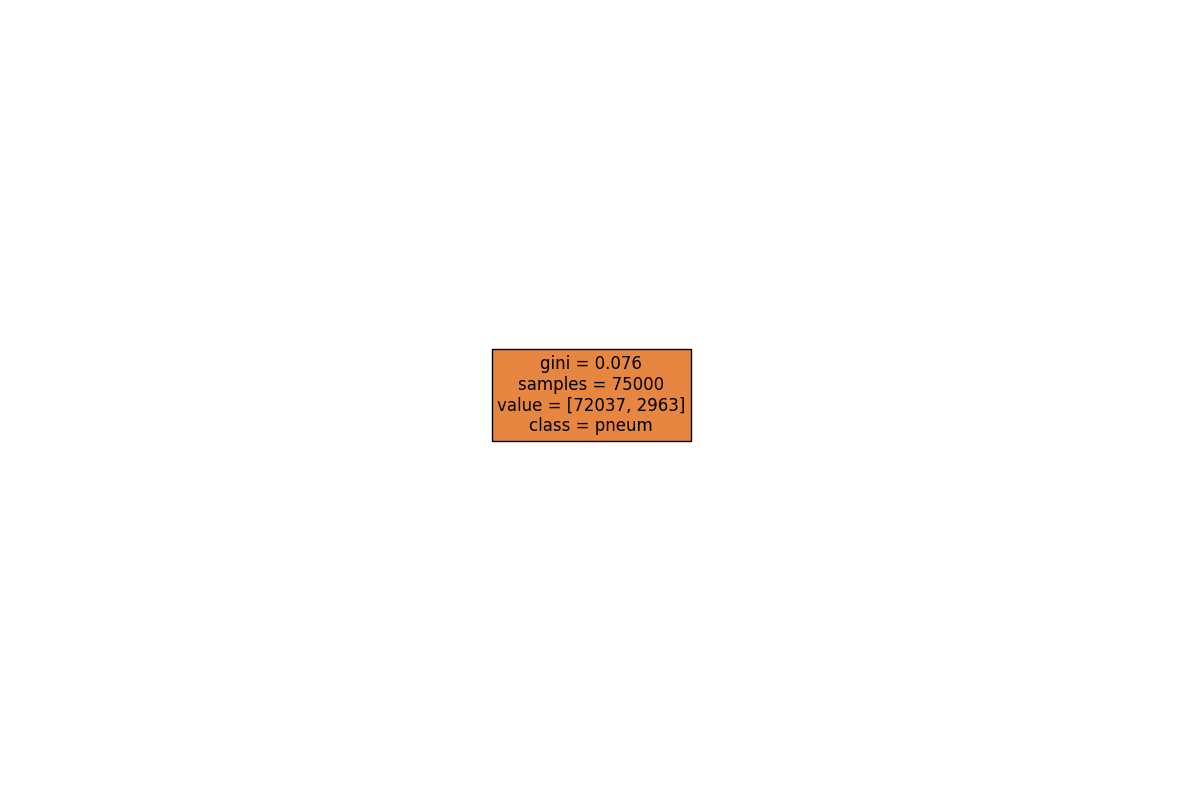

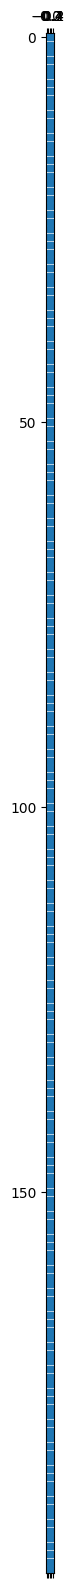

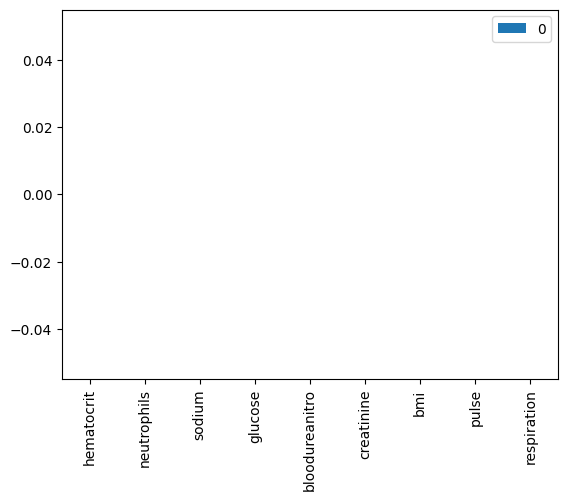

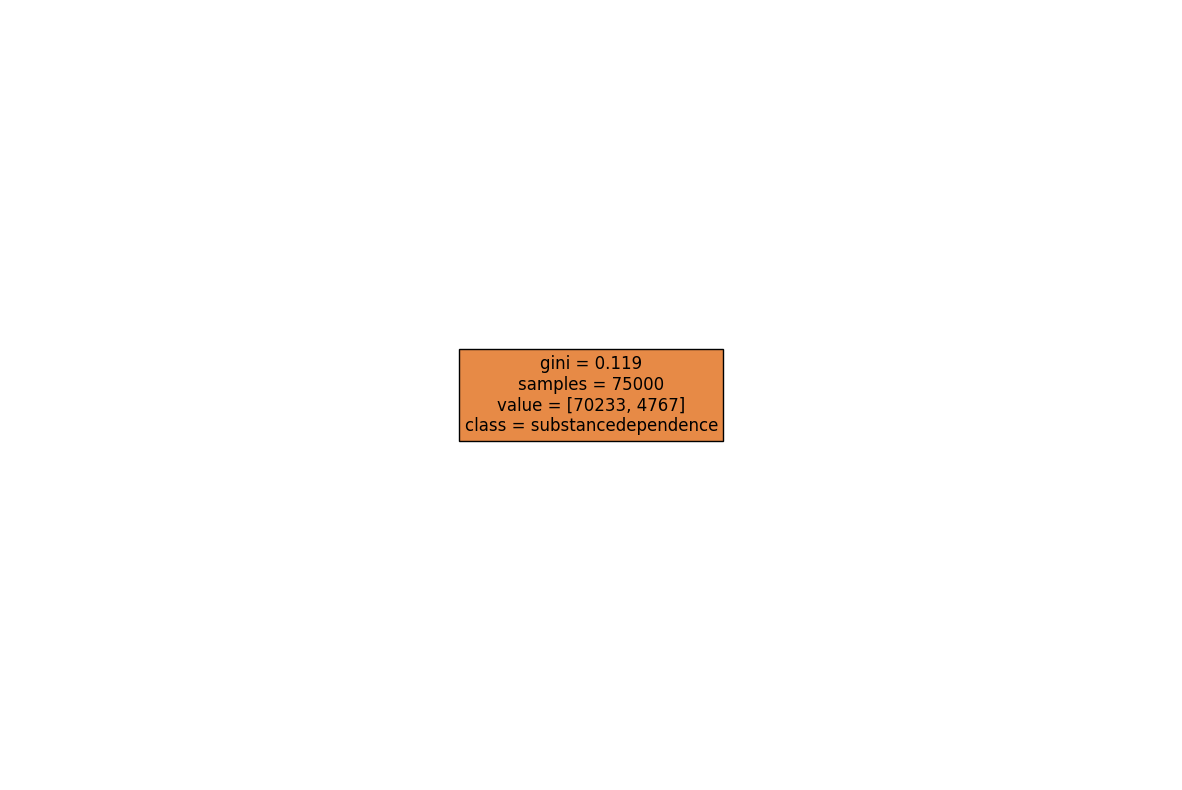

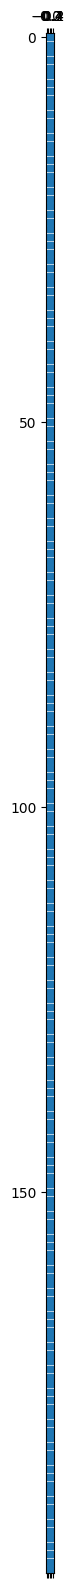

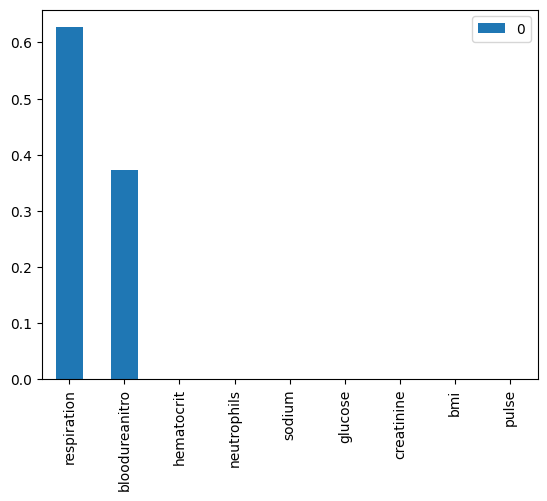

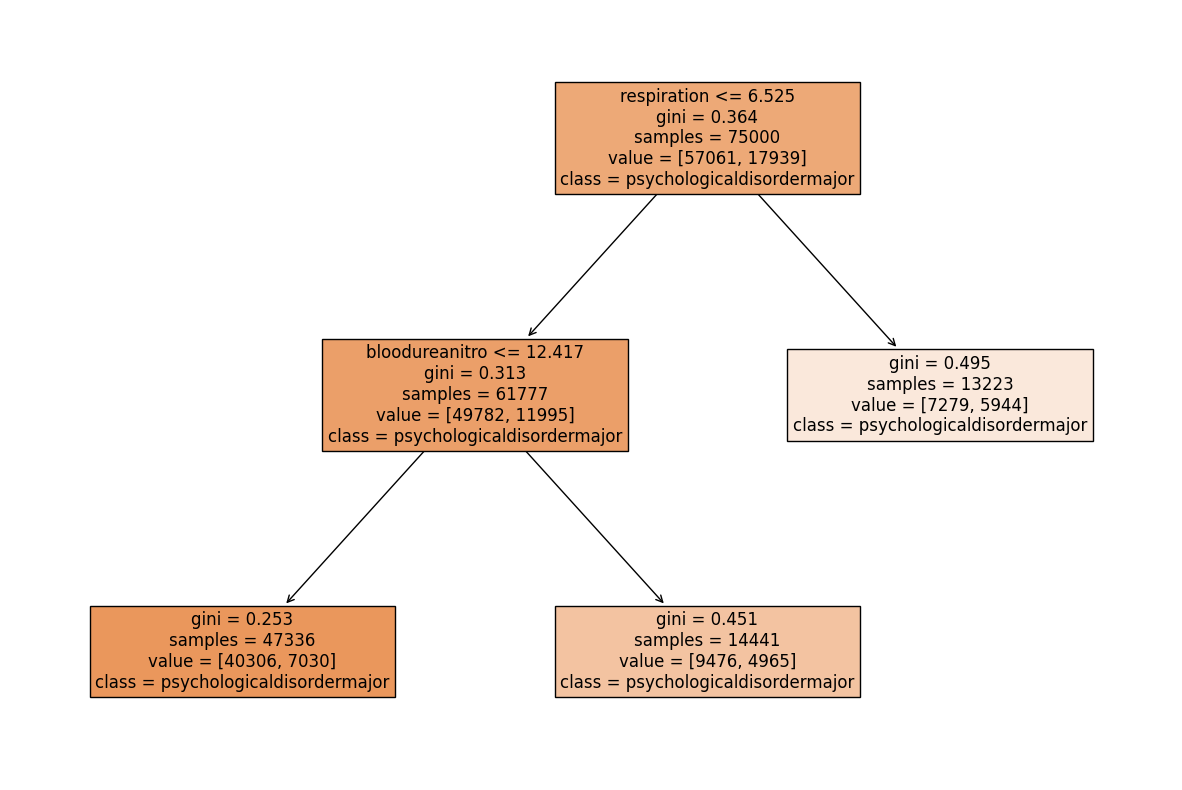

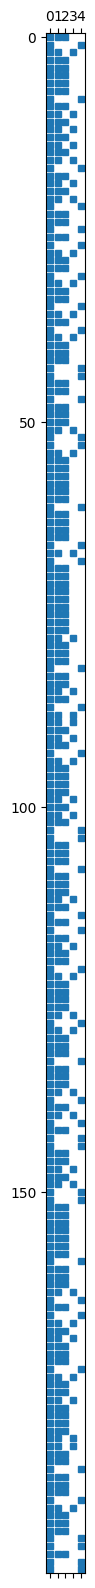

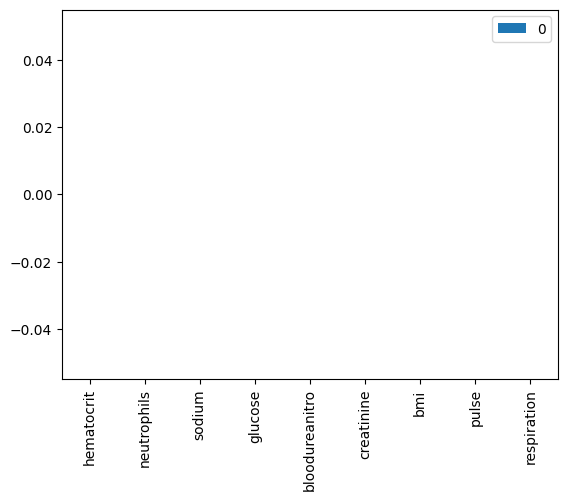

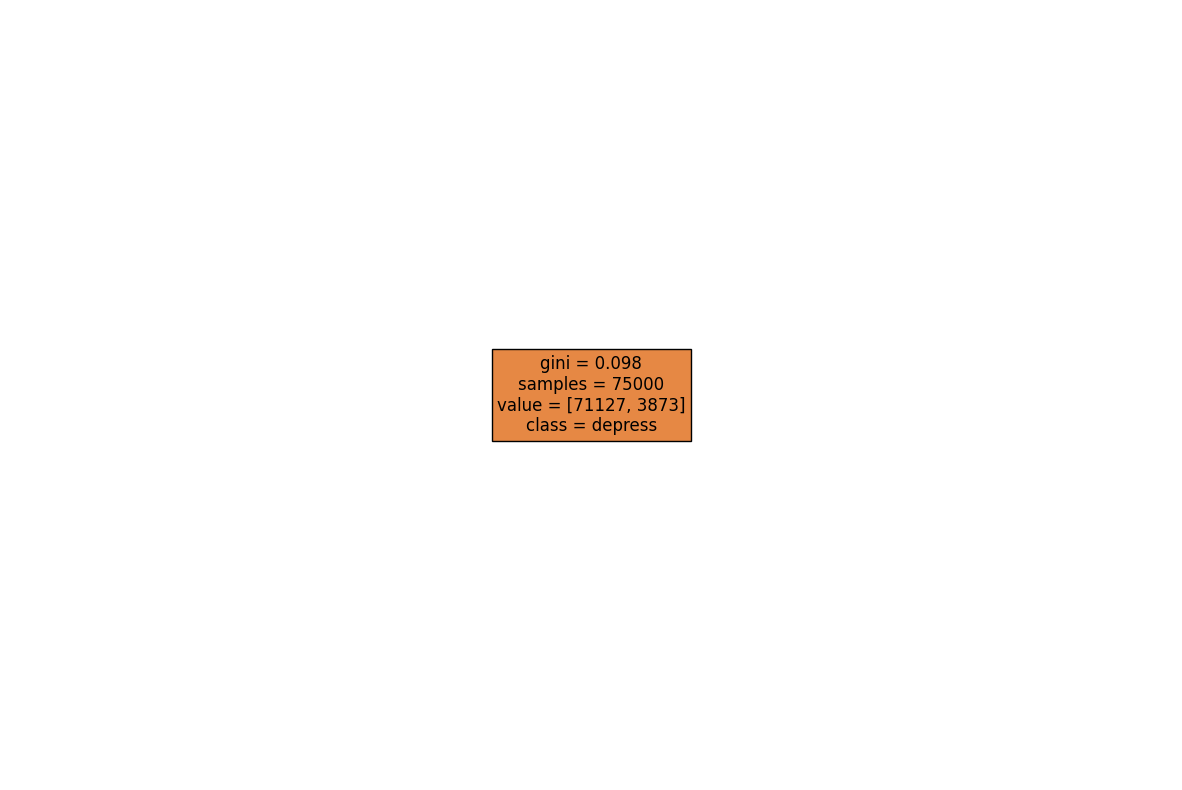

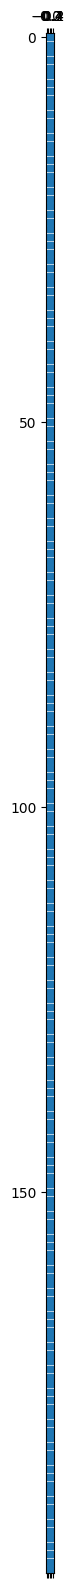

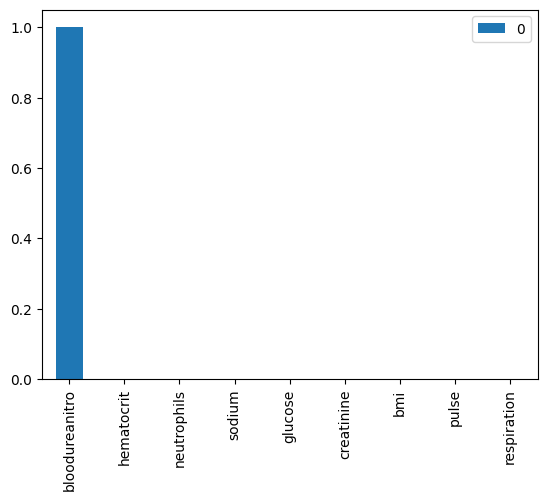

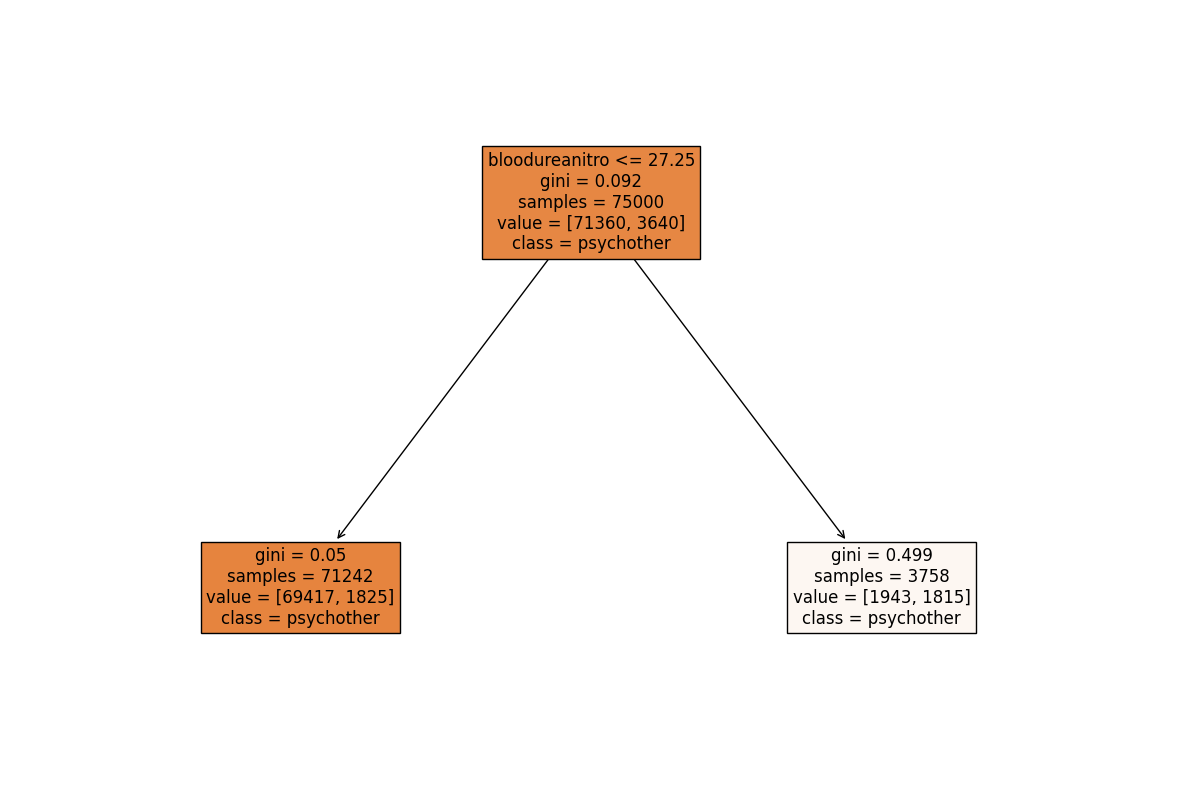

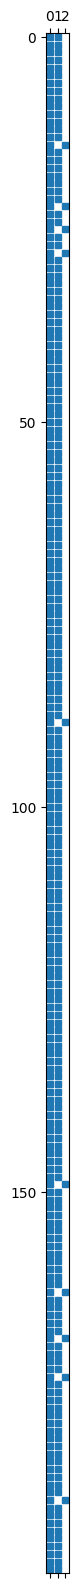

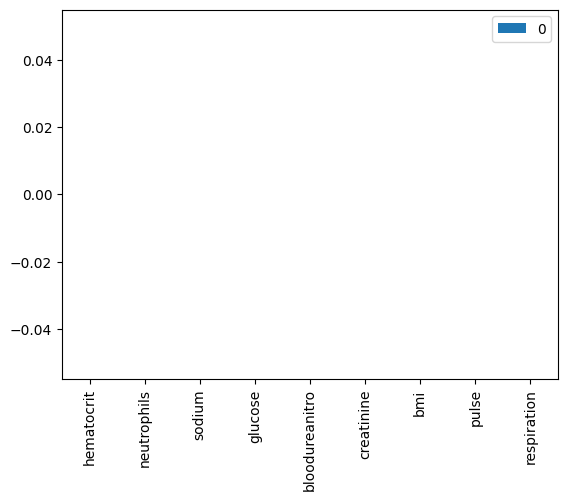

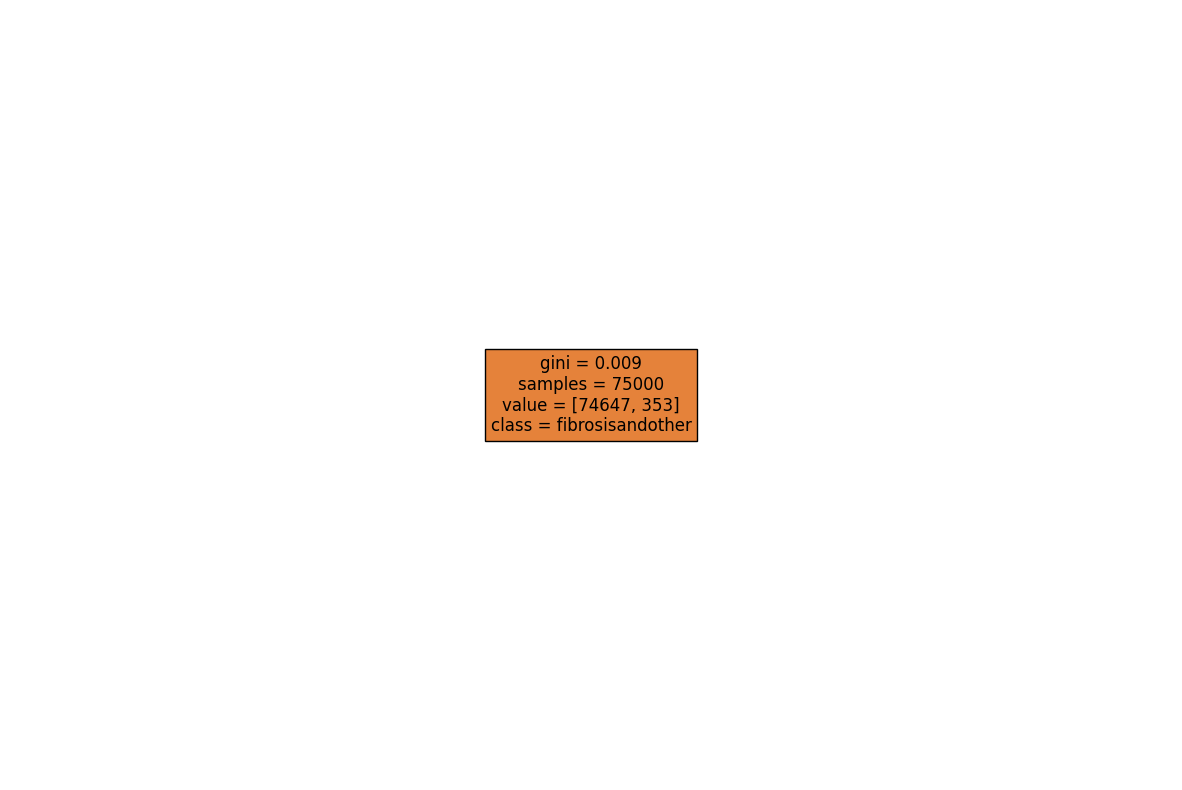

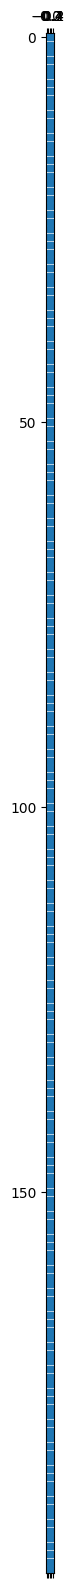

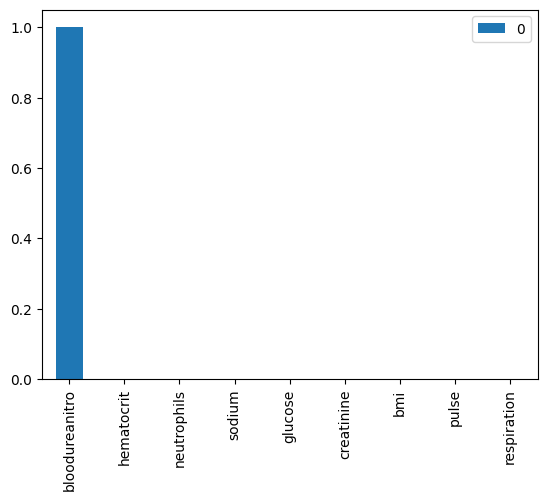

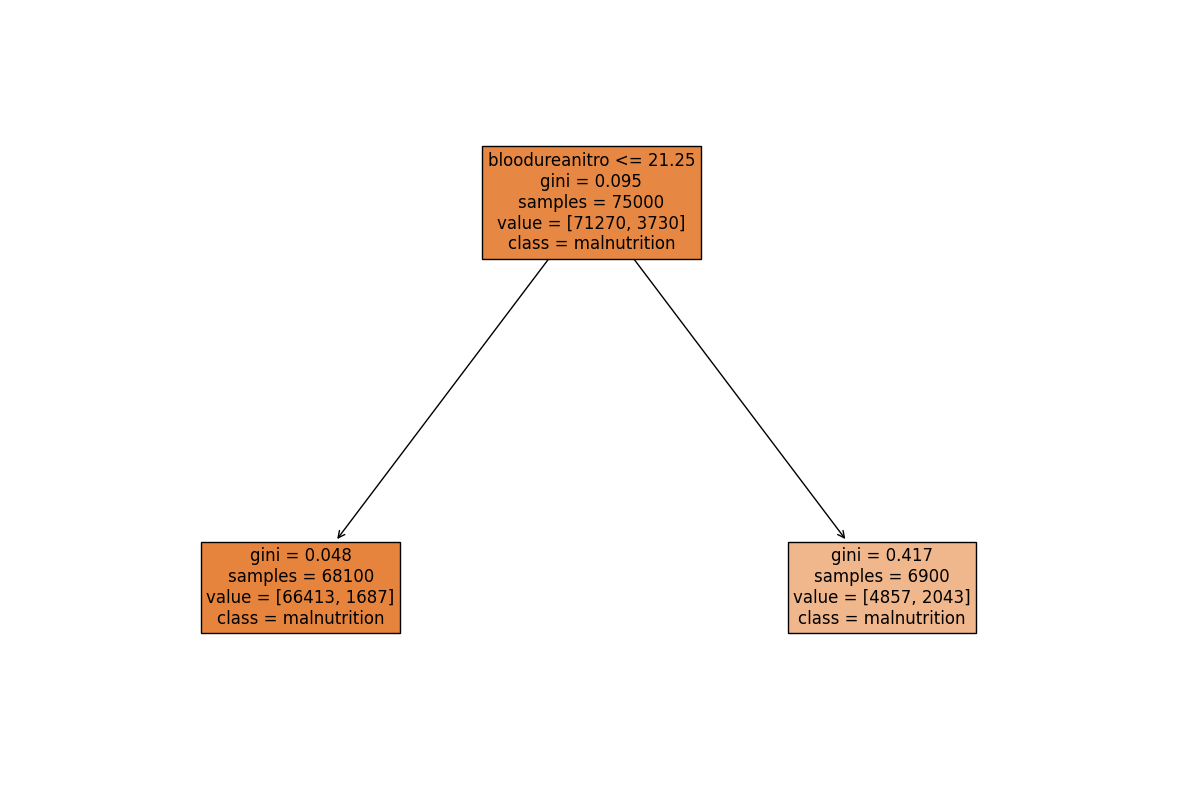

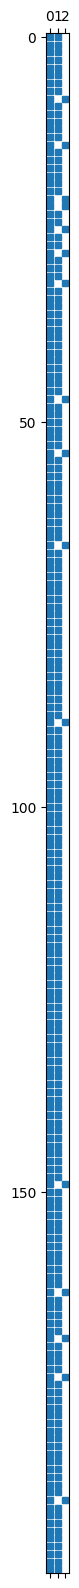

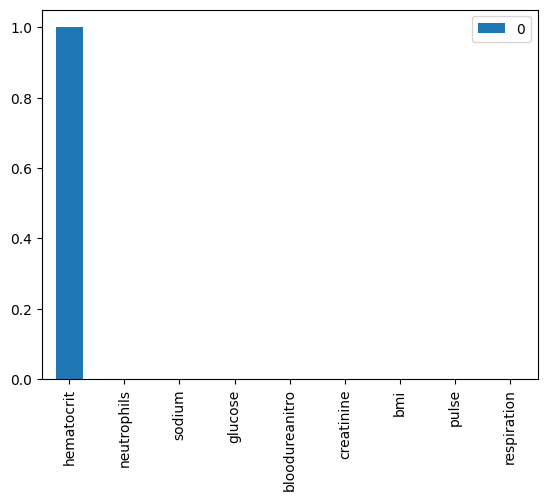

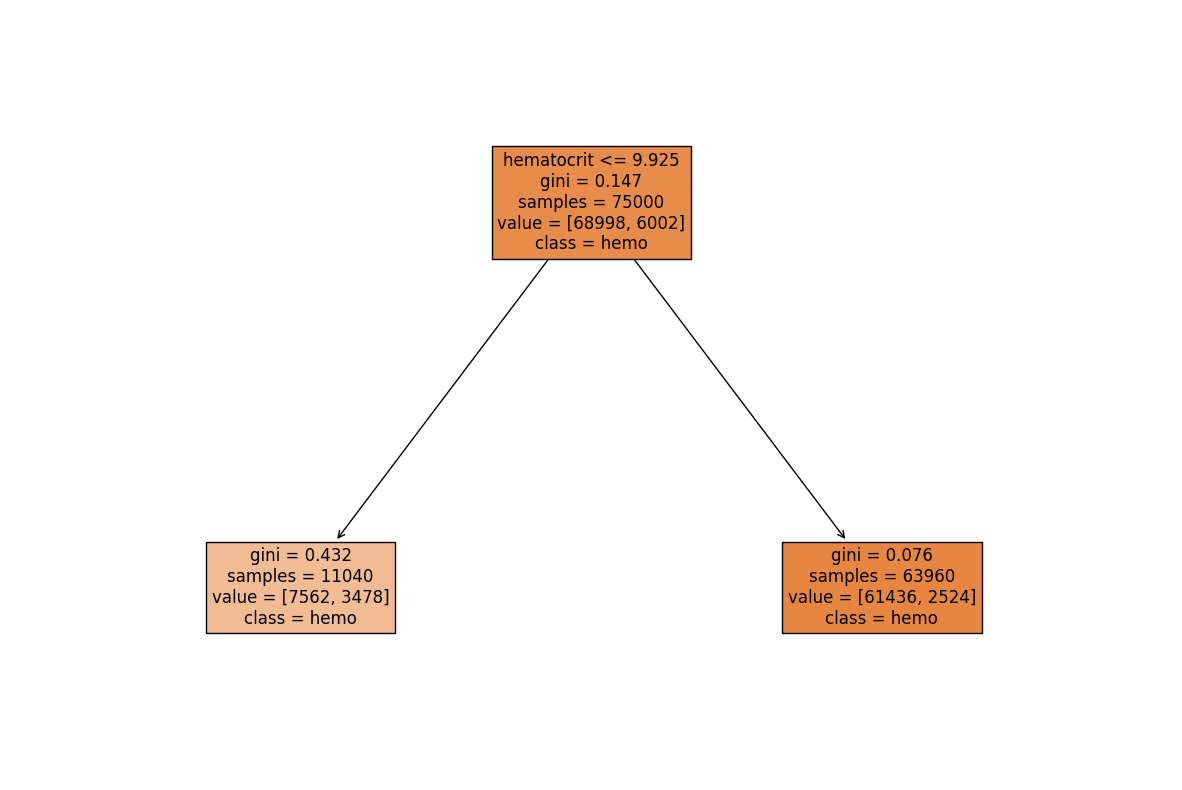

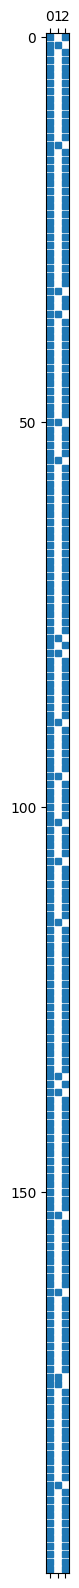

In [39]:
from sklearn.tree import DecisionTreeClassifier
for col in bin_cols:
  print("The col used:", col)
  clf = DecisionTreeClassifier(max_depth = 4, ccp_alpha = 0.01)
  clf = clf.fit(x_train, y_train[col])
  clf.get_params()
  predictions = clf.predict(x_test)
  predictions
  clf.predict_proba(x_test)
  accuracy_score(y_test[col], predictions)
  confusion_matrix(y_test[col], predictions, labels = [0 , 1])
  precision_score(y_test[col], predictions, labels = np.unique(predictions))
  print(classification_report(y_test[col], predictions, target_names=[f'no {col}', f'{col}']))
  feature_names = X.columns
  feature_importance = pd.DataFrame(clf.feature_importances_, index = feature_names).sort_values(0, ascending=False)
  features = list(feature_importance[feature_importance[0]>0].index)
  feature_importance.head(10).plot(kind='bar')
  fig = plt.figure(figsize=(15,10))
  _ = tree.plot_tree(clf, 
                   feature_names=feature_names,  
                   class_names={0:f'{col}', 1: f'no {col}' },
                   filled=True,
                  fontsize=12)
  clf.decision_path(x_test)
  sparse = clf.decision_path(x_test).toarray()[:101]
  plt.figure(figsize=(20, 20))
  plt.spy(sparse, markersize=5)

In [ ]:
 def calculate_number_of_issues(df, bin_cols):
    df["numberofissues"] = df[bin_cols].sum(axis=1)
    return df
df = calculate_number_of_issues(training_data, bin_cols)
#retrieving the frequency for number of issues 

3.Modelling using shap

In [ ]:
labels, features = df[["lengthofstay"]], df[num_cols]
labels.value_counts()

lengthofstay
1               17979
3               16068
4               14822
2               12825
5               12116
6               10362
7                7263
8                4652
9                2184
10               1000
11                460
12                137
13                 75
14                 31
15                 16
16                  6
17                  4
dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels) #Feat

In [ ]:
#[AAYUSH CHOUDHURY]. ([2022; September]). [LengthOfStay], [csv files]. Retrieved [01/05/2023] from [https://www.kaggle.com/datasets/aayushchou/hospital-length-of-stay-dataset-microsoft].
regressor = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), num_cols),
    ], remainder="passthrough"),
    LGBMRegressor(n_jobs=-1)
)
regressor.fit(x_train, y_train)
preds = np.round(regressor.predict(x_test), 0)
r2_score(preds, y_test)

-1.6649110151584736

In [ ]:
explainer = shap.Explainer(regressor[1], feature_names=regressor[:-1].get_feature_names_out())

observations = regressor[0].transform(x_test)
shap_values = explainer(observations)
shap_values.shape

(25000, 9)

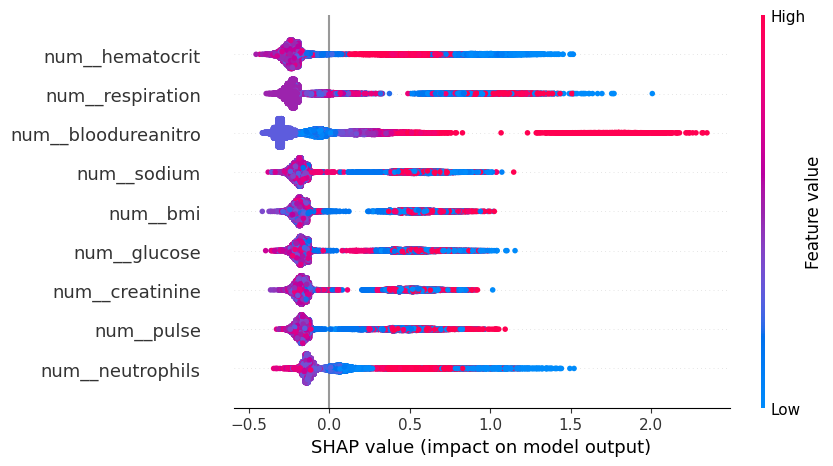

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.plots.beeswarm(shap_values,  max_display=30)
plt.savefig('beeswarm_lengthofstay.jpg')